# Manolo Ramírez Pintor - A01706155
## Clasificador de imágenes en Keras - CNN
### Protagonizado por los personajes de Tom y Jerry (binario)

### Importando las librerías
A continuación importaremos las librerías que vamos a utilizar para el entrenamiento de nuestro modelo de clasificación. Usaremos Google Tensorflow con redes convolucionales de Keras.

In [ ]:
# !unzip tom_and_jerry.zip

In [1]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import random
import cv2

from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image 
from keras.models import Sequential
from keras.utils import img_to_array
from keras.utils import load_img
from keras import models

import splitfolders

In [4]:
!ls

gdrive	j4.jpg	logs_AD      spike.jpg	t.jpg		    tom_and_jerry_AD.h5
j2.jpg	j.jpg	output	     t2.jpg	tom_and_jerry	    tom_y_black.jpeg
j3.jpg	logs	sample_data  t3.jpg	tom_and_jerry_1.h5  tom_y_jerry.jpg


### Analizando los archivos...
Aquí estaremos revisando primero los archivos que tenemos, dividiremos los datos entre entrenamiento, validación y pruebas.

In [5]:
directorio = '/content/gdrive/MyDrive/IA/tom_and_jerry'

In [6]:
!cp -r /content/gdrive/MyDrive/IA/tom_and_jerry ./tom_and_jerry

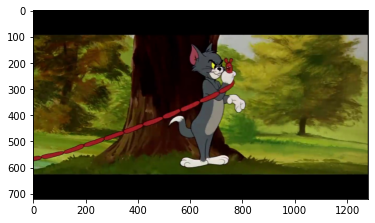

In [7]:
# Analizamos las imagenes que tenemos
# img = cv2.imread('/content/gdrive/MyDrive/IA/tom_and_jerry/tom/frame1000.jpg')
img = cv2.imread('./tom_and_jerry/tom/frame1000.jpg')
img.shape

# Podemos observar que tenemos imagenes de 1280x720p, RGB
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

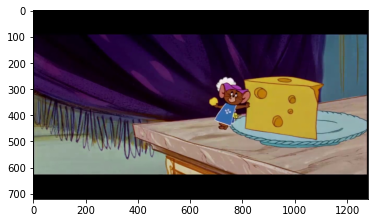

In [8]:
# Analizamos las imagenes que tenemos
# img = cv2.imread('/content/gdrive/MyDrive/IA/tom_and_jerry/jerry/frame100.jpg')
img = cv2.imread('./tom_and_jerry/jerry/frame100.jpg')
img.shape

# Podemos observar que tenemos imagenes de 1280x720p, RGB
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

## Generando el dataset...
Aquí usaremos el API de TensorFlow para almacenar nuestros datos a una variable, se nos facilitará para accesar a los archivos.

In [10]:
# Por defecto, las imagenes son escaladas a 256x256 pixeles
data = tf.keras.utils.image_dataset_from_directory(
    # '/content/gdrive/MyDrive/IA/tom_and_jerry',
    './tom_and_jerry',
    batch_size=8,
    shuffle=True,
    interpolation='bilinear',
    crop_to_aspect_ratio=False,
)

Found 3170 files belonging to 2 classes.


Creamos un iterador de datos ya que todo no es precargado en la memoria RAM, así que lo hacemos un iterador de numpy.

In [11]:
data_iterator = data.as_numpy_iterator()

Con esto, obtendremos un batch del dataset que creamos con Keras.

In [12]:
batch = data_iterator.next()
len(batch) # Images and labels

2

Aquí podemos observer lo que TensorFlow creó, un batch de 32 de imágenes de 256x256, RGB.

In [13]:
# Imagenes representadas como arrays de numpy
batch[0].shape

(8, 256, 256, 3)

Aquí obtendremos los labels que nos indican si es Tom o es Jerry quien está presente en la imagen.

In [14]:
# Labels: 0 Jerry, 1 Tom
batch[1]

array([1, 1, 1, 0, 0, 1, 0, 0], dtype=int32)

Para revisar quiénes son 1 o 0, vamos a revisar visualmente creando un gráfico de los datos que tenemos.

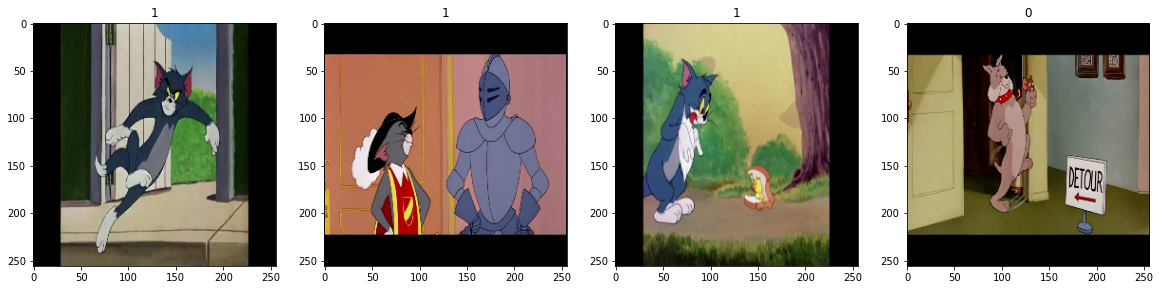

In [15]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

Podemos ver que Jerry pertenece a 0 y Tom pertenece a 1

## Preprocesado de datos:
Ahora, preprocesaremos estas imagenes para que los colores de 0-255 tengan valores de 0-1, esto ayuda a que el modelo entrene mejor y obtengamos resultados más generalizados.
También, vamos a dividir los datos en training, test y validation para asegurarnos de no hacer un overfit en nuestro modelo.

In [16]:
data = data.map(lambda x, y: (x/255, y))

Si observamos nuestro batch siguiente, podemos observar que ya tenemos los valores normalizados:

In [17]:
scaled_iterator = data.as_numpy_iterator()

In [18]:
batch = scaled_iterator.next()

Valores normalizados:

In [19]:
scaled_iterator.next()[0].max()

1.0

In [20]:
scaled_iterator.next()[0].min()

0.0

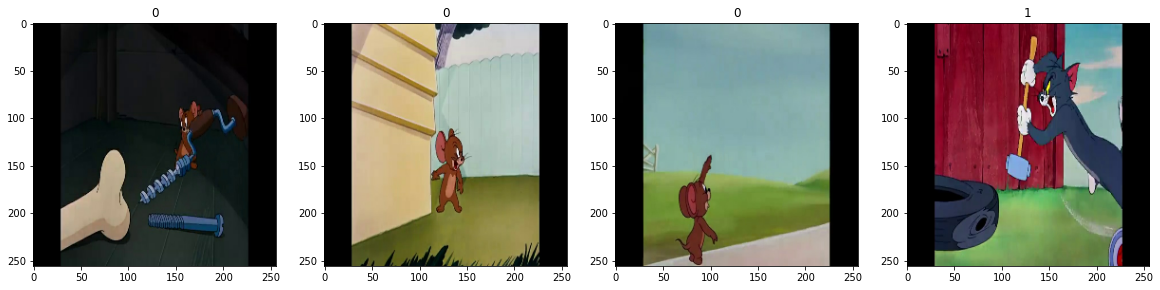

In [21]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

#### Dividiendo el dataset
Ahora, dividiremos entre test, train y validation

In [22]:
# Numero de batches generados:
len(data) # Cada uno tiene 32 imagenes.

397

In [23]:
# Calculando el tamaño de los batches
train_size = int(len(data)*.8)
val_size = int(len(data)*.1)
test_size = int(len(data)*.1)

In [24]:
# Verificando que sea igual a nuestro numero de batches
(train_size+2)+val_size+test_size

397

Ahora tomamos los datos con take y skip, aquí ya estamos tomando directamente todos los datos para los sets diferentes.

In [25]:
# NOTA: En la parte donde usamos Keras para importar/generar el dataset
#       por defecto ya existe un shuffle.
train = data.take(train_size+2)
val = data.skip(train_size+2).take(val_size)
test = data.skip((train_size+2)+val_size).take(test_size)

## Modelo de Deep Learning
Ahora, en esta parte estaremos creando el modelo para entrenar nuestros datos y comenzar a obtener las predicciones que buscamos realizar con estas imágenes.   

Vamos a usar Keras Sequential para construir nuestro modelo de capas. Este contendrá redes convolucionales.   

El modelo secuencial lo usaremos ya que sólo estamos trabajando con una entrada y una salida. Existen otros tipos como el funcional, donde tenemos distintas entradas y salidas en el modelo, estos son de uso más avanzado y por el momento no los estaremos viendo.   

Las capas que estaremos usando son las de Conv2D, MaxPooling2D, Dense, Flatten y Dropout. Estas nos ayudarán a construir nuestro modelo convolucional. Las demás nos funcionarán como filtros, por ejemplo MaxPooling hace un condensado de todo y toma las características más importantes. Flatten para ir de canales y kernels para regresar a una salida y dropout para conseguir regularización en nuestro modelo.

Teniendo en cuenta lo anterior, crearemos nuestro modelo:

In [26]:
model = Sequential()

Ahora vamos a añadir algunas capas (y bloques de convoluciones) a nuestro modelo:

In [27]:
# Este es el Modelo 5 (más adelante podemos ver por qué)

# Establecemos primero la entrada de nuestro modelo...
# 1. Numero de filtros
# 2. Tamaño del filtro
# 3. Desplazamiento del filtro
# 4. Función de activación (relu, sigmoid, etc)
# 5. Formato de entrada (256px, 256px, 3RGB)

# Primer bloque convolutivo, entrada de una neurona
model.add(Conv2D(16, (4,4), 1, activation='relu', input_shape=(256, 256, 3)))
# Reduce la información a la mitad, pero se queda con lo más importante
model.add(MaxPooling2D())

# Segundo bloque convolutivo
model.add(Conv2D(24, (4,4), 1, activation='relu'))
model.add(MaxPooling2D())

# Tercer bloque convolutivo
model.add(Conv2D(16, (8,8), 2, activation='relu'))
model.add(MaxPooling2D())

# Dropout (desactivación de neuronas aleatoriamente)
# Esto ayuda mucho a no hacer overfit en el train y que aprenda.
model.add(Dropout(0.2))

# Cuarto bloque convolutivo
model.add(Conv2D(64, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))

model.add(Dense(1, activation='sigmoid')) # Salida de una neurona 0-1

**Modelos descartados**   
Estos son algunos de los modelos que descarté durante las pruebas que realicé moviendo hiperparámetros, creando nuevas capas (o bloques) convolutivos, modificando sus parámetros internos, métodos de activación, poniendo dropouts entre bloques y más.

In [54]:
# ----------------------- MODELO 1 ----------------------------------
# # Primer bloque convolutivo, entrada de una neurona
# model.add(Conv2D(16, (4,4), 1, activation='relu', input_shape=(64, 64, 3)))
# # Reduce la información a la mitad, pero se queda con lo más importante
# model.add(MaxPooling2D())

# # Primer bloque convolutivo
# model.add(Conv2D(16, (2,2), 1, activation='relu'))
# model.add(MaxPooling2D())

# # Segundo bloque convolutivo
# model.add(Conv2D(64, (3,3), 1, activation='relu'))
# model.add(MaxPooling2D())

# model.add(Flatten())

# model.add(Dense(64, activation='relu'))

# model.add(Dense(1, activation='sigmoid')) # Salida de una neurona 0-1



# ----------------------- MODELO 2 ----------------------------------
# # Primer bloque convolutivo, entrada de una neurona
# model.add(Conv2D(24, (3,3), 1, activation='relu', input_shape=(128, 128, 3)))
# # Reduce la información a la mitad, pero se queda con lo más importante
# model.add(MaxPooling2D())

# # Segundo bloque convolutivo
# model.add(Conv2D(8, (2,2), 1, activation='relu'))
# model.add(MaxPooling2D())

# # Tercer bloque convolutivo
# model.add(Conv2D(16, (6,6), 1, activation='tanh'))
# model.add(MaxPooling2D())

# model.add(Flatten())

# model.add(Dense(128, activation='relu'))

# model.add(Dense(1, activation='sigmoid')) # Salida de una neurona 0-1



# ----------------------- MODELO 3 ----------------------------------
# # Primer bloque convolutivo, entrada de una neurona
# model.add(Conv2D(24, (3,3), 1, activation='relu', input_shape=(256, 256, 3)))
# # Reduce la información a la mitad, pero se queda con lo más importante
# model.add(MaxPooling2D())

# # Segundo bloque convolutivo
# model.add(Conv2D(8, (2,2), 1, activation='relu'))
# model.add(MaxPooling2D())

# # Tercer bloque convolutivo
# model.add(Conv2D(64, (6,6), 1, activation='tanh'))
# model.add(MaxPooling2D())

# model.add(Dropout(0.35))

# # Cuarto bloque convolutivo
# model.add(Conv2D(16, (3,3), 1, activation='relu'))
# model.add(MaxPooling2D())

# model.add(Flatten())

# model.add(Dense(256, activation='relu'))

# model.add(Dense(1, activation='sigmoid')) # Salida de una neurona 0-1



# ----------------------- MODELO 4 ----------------------------------
# # Primer bloque convolutivo, entrada de una neurona
# model.add(Conv2D(8, (2,2), 2, activation='relu', input_shape=(256, 256, 3)))
# # Reduce la información a la mitad, pero se queda con lo más importante
# model.add(MaxPooling2D())

# # Segundo bloque convolutivo
# model.add(Conv2D(32, (3,3), 1, activation='relu'))
# model.add(MaxPooling2D())

# # Tercer bloque convolutivo
# model.add(Conv2D(64, (2,2), 1, activation='relu'))
# model.add(MaxPooling2D())

# model.add(Dropout(0.5))

# # Cuarto bloque convolutivo
# model.add(Conv2D(128, (2,2), 1, activation='relu'))
# model.add(MaxPooling2D())

# model.add(Flatten())

# model.add(Dense(256, activation='relu'))

# model.add(Dense(1, activation='sigmoid')) # Salida de una neurona 0-1

Ahora que tenemos nuestro modelo creado, vamos a compilarlo.

In [28]:
# Compilando el modelo...
# Establecemos el optimizador que queremos usar.
# Existen varios y cada uno sirve para varios casos.
# La función pérdida la definimos como un Binary porque sólo tenemos dos resultados.
# La metrica que buscamos obtener por el momento es el accuracy.
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

Ahora observaremos cómo está construído nuestro modelo:   

Aquí podemos ver exactamente cómo está funcionando el modelo, las neuronas y capas que tenemos y en sí el número de parámetros totales que se mueven mientras se va realizando el entrenamiento del modelo.

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 253, 253, 16)      784       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 123, 123, 24)      6168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 61, 61, 24)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 27, 27, 16)        24592     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 16)       0

## Entrenamiento del modelo
Ahora vamos a crear una ubicación para guardar el resultado de nuestro modelo para poderlo probar más adelante en otro notebook, ya sea con imagenes de validación o nuevas que saque desde otro lado.

In [30]:
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [58]:
# !sudo rm -rf logs

Ahora realizaremos el fit del modelo como tal, estableceremos con qué queremos entrenar, el número de épocas, el dataset de validación para ejecutar inmediatamente una autoevaluación y le daremos un callback para tener análisis más a futuro si es que los queremos.

In [31]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
319/319 [==============================] - 24s 59ms/step - loss: 0.6509 - accuracy: 0.6238 - val_loss: 0.6282 - val_accuracy: 0.6891
Epoch 2/20
319/319 [==============================] - 19s 60ms/step - loss: 0.5193 - accuracy: 0.7426 - val_loss: 0.3028 - val_accuracy: 0.8750
Epoch 3/20
319/319 [==============================] - 19s 60ms/step - loss: 0.2770 - accuracy: 0.8817 - val_loss: 0.2529 - val_accuracy: 0.8942
Epoch 4/20
319/319 [==============================] - 19s 61ms/step - loss: 0.2081 - accuracy: 0.9161 - val_loss: 0.1746 - val_accuracy: 0.9231
Epoch 5/20
319/319 [==============================] - 16s 51ms/step - loss: 0.1394 - accuracy: 0.9502 - val_loss: 0.1476 - val_accuracy: 0.9391
Epoch 6/20
319/319 [==============================] - 20s 61ms/step - loss: 0.1048 - accuracy: 0.9639 - val_loss: 0.1888 - val_accuracy: 0.9327
Epoch 7/20
319/319 [==============================] - 21s 66ms/step - loss: 0.0845 - accuracy: 0.9690 - val_loss: 0.1687 - val_accuracy:

In [32]:
model.save('tom_and_jerry_1.h5')

Si vamos que el loss baja está bien, si vamos que el val_loss baja está bien, pero si sube significa que existe un overfitting en el modelo y que necesitamos aplicar regularización, ver si los datos están bien o cambiar los datos o considerar una red neuronal más grande o más sotisficada.

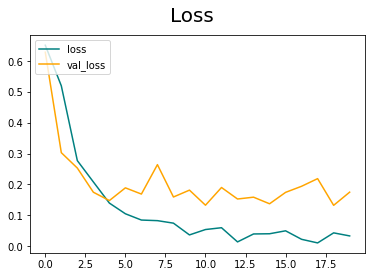

In [33]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

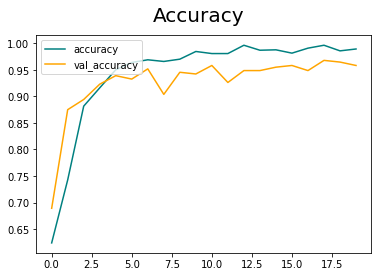

In [34]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

## Evaluando el modelo
Ya que entrenamos nuestro modelo, veremos con un set de datos de pruebas la presición, recall y accuracy que tiene, con datos que nunca se han visto.

In [35]:
from keras.metrics import Precision, Recall, BinaryAccuracy

In [36]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [37]:
# Numero de batches para probar
len(test)

39

In [38]:
for batch in test.as_numpy_iterator():
  X, y = batch
  yhat = model.predict(X)
  pre.update_state(y, yhat)
  re.update_state(y, yhat)
  acc.update_state(y, yhat)

1/1 [==============================] - 0s 105ms/step


Entre presición más alta significa que el modelo está haciendo un buen perform

Recall alto significa que el modelo también tiene buen perform

Accuracy también entre más alto mejor

In [39]:
print(pre.result().numpy(), re.result().numpy(), acc.result().numpy())

0.97354496 0.9583333 0.9575163


## Probando con datos de fuera:

In [58]:
img = load_img('j.jpg',  target_size=(256,256))
img_tensor = img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis = 0)
img_tensor /= 255.

In [41]:
model = models.load_model("tom_and_jerry_1.h5")

1/1 [==============================] - 0s 16ms/step
[[0.99990654]]
class  1 confindence
TOM


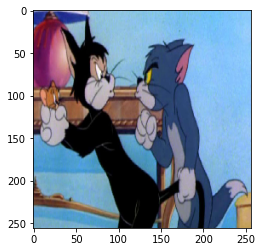

In [59]:
#model response
confidence = model.predict(img_tensor)
predict_class = (confidence > 0.5).astype("int32")
print (confidence)
print ("class ", predict_class[0][0], "confindence", )

if predict_class[0][0] == 0:
  print("JERRY")
else:
  print("TOM")

plt.imshow(img_tensor[0])
plt.show()

## Utilizando aumento de datos
Después de haber probado varias formas de modificar las capas e hiperparámetros, supe que todavía existía un área de oportunidad para los datos de entrenamiento ya que parece que los modelos que estoy creando quieren funcionar bien, de acuerdo a los gráficos y valores de pérdida bajos que he estado obteniendo últimamente.   

Bien, ahora hagamos aumento de datos con la herramienta de Keras ImageDataGenerator

In [88]:
# Troubleshooting
# !sudo rm -rf output

In [89]:
# Como no encontré la forma de separar entre train, val y test usando las
# propias herramientas de TensorFlow, haré separación a través de split-folders:
splitfolders.ratio(
    directorio, 
    output="output", 
    seed=1800, 
    ratio=(.8, .1, .1), 
    group_prefix=None, 
    move=False)

Copying files: 3170 files [00:08, 387.37 files/s]


In [60]:
data_2 = tf.keras.utils.image_dataset_from_directory(
    './output/train',
    batch_size=8,
    shuffle=True,
    interpolation='bilinear',
    crop_to_aspect_ratio=False,
)

data_iterator_2 = data_2.as_numpy_iterator()

batch_2 = data_iterator_2.next()

batch_2[0].shape


Found 2536 files belonging to 2 classes.


(8, 256, 256, 3)

In [ ]:
# # Save augmented images to file
# from tensorflow.keras.datasets import mnist
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# import matplotlib.pyplot as plt
# # load data
# (X_train, y_train), (X_test, y_test) = mnist.load_data()
# # reshape to be [samples][width][height][channels]
# X_train = X_train.reshape((X_train.shape[0], 28, 28, 1))
# X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))
# # convert from int to float
# X_train = X_train.astype('float32')
# X_test = X_test.astype('float32')
# # define data preparation
# datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
# # configure batch size and retrieve one batch of images
# for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9, shuffle=False,
#                                      save_to_dir='images', save_prefix='aug', save_format='png'):
#     # create a grid of 3x3 images
#     fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(4,4))
#     for i in range(3):
#         for j in range(3):
#             ax[i][j].imshow(X_batch[i*3+j].reshape(28,28), cmap=plt.get_cmap("gray"))
#     # show the plot
#     plt.show()
#     break

In [ ]:
# for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9, shuffle=False,
#                                      save_to_dir='images', save_prefix='aug', save_format='png'):
#     # create a grid of 3x3 images
#     fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(4,4))
#     for i in range(3):
#         for j in range(3):
#             ax[i][j].imshow(X_batch[i*3+j].reshape(28,28), cmap=plt.get_cmap("gray"))
#     # show the plot
#     plt.show()
#     break

In [61]:
train_datagen = ImageDataGenerator(
							rescale = 1./255,
							# rotation_range = 15,
							# width_shift_range = 0.2,
							# height_shift_range = 0.2,
							# shear_range = 1,
							# zoom_range = [0.6, 1],
							horizontal_flip = True)

# Con y sin esto, algo está causando problemas...
train_datagen.fit(batch_2[0])

train_new = train_datagen.flow_from_directory(
    './output/train',
		target_size = (256, 256),
    batch_size=8,
		class_mode ='binary',
    interpolation='bilinear')

val_datagen = ImageDataGenerator(1./255)

val_new = val_datagen.flow_from_directory(
    './output/val',
		target_size = (256, 256),
    batch_size=8,
		class_mode ='binary',
    interpolation='bilinear')

test_datagen = ImageDataGenerator(1./255)

test_new = test_datagen.flow_from_directory(
    './output/test',
		target_size = (256, 256),
    batch_size=8,
		class_mode ='binary',
    interpolation='bilinear')

Found 2536 images belonging to 2 classes.
Found 317 images belonging to 2 classes.
Found 317 images belonging to 2 classes.


Podemos observar que ahora contamos con imagenes transformadas para trabajar en nuestro modelo.

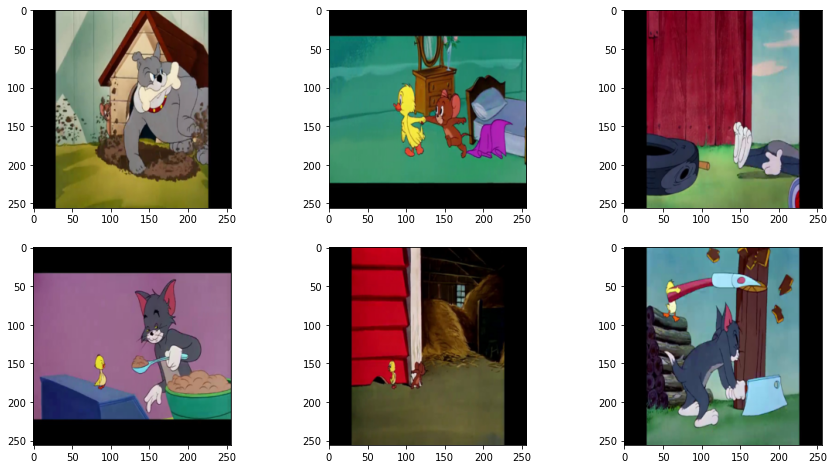

In [62]:
plt.figure(figsize=(15, 8))
for imagen, etiqueta in train_new:
  for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(imagen[i])
  break

Usaremos el mismo modelo que hizo un buen perform sin hacer data augmentation y compararemos los resultados. 

In [63]:
# Modelo para Data Augmentation
model_AD = Sequential()

In [64]:
# ----------------------- MODELO 5 ----------------------------------

# Establecemos primero la entrada de nuestro modelo...
# 1. Numero de filtros
# 2. Tamaño del filtro
# 3. Desplazamiento del filtro
# 4. Función de activación (relu, sigmoid, etc)
# 5. Formato de entrada (256px, 256px, 3RGB)

# Primer bloque convolutivo, entrada de una neurona
model_AD.add(Conv2D(16, (4,4), 1, activation='relu', input_shape=(256, 256, 3)))
# Reduce la información a la mitad, pero se queda con lo más importante
model_AD.add(MaxPooling2D())

# Segundo bloque convolutivo
model_AD.add(Conv2D(24, (4,4), 1, activation='relu'))
model_AD.add(MaxPooling2D())

# Tercer bloque convolutivo
model_AD.add(Conv2D(16, (8,8), 2, activation='relu'))
model_AD.add(MaxPooling2D())

# Dropout (desactivación de neuronas aleatoriamente)
# Esto ayuda mucho a no hacer overfit en el train y que aprenda.
model_AD.add(Dropout(0.2))

# Cuarto bloque convolutivo
model_AD.add(Conv2D(64, (3,3), 1, activation='relu'))
model_AD.add(MaxPooling2D())

model_AD.add(Flatten())

model_AD.add(Dense(256, activation='relu'))

model_AD.add(Dense(1, activation='sigmoid')) # Salida de una neurona 0-1

In [65]:
model_AD.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])
model_AD.summary()

logdir = 'logs_AD'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 253, 253, 16)      784       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 126, 126, 16)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 123, 123, 24)      6168      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 61, 61, 24)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 61, 61, 24)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 27, 27, 16)       

### Entrando con problemas
Por alguna razón, con los datos que estoy trabajando encontré bugs en las librerías de Tensorflow para realizar el entrenamiento de este modelo. Busqué varias formas de solucionarlo, poco a poco fui avanzando pero nuevamente salían más problemas. Pensé en hacer aumento de datos de forma manual pero encontraba formas de hacerlo descontinuadas y hacerlo de forma totalmente manual iba a ser muy tardado.   

Considero que hay algo que se buguea o glitchea dentro de las librerías porque por más que cambie el modelo, o no mejora o se queda en el mismo accuracy como si no estuviera haciendo absolutamente nada.   

**Actualización:** Al final logré que se movieran los valores añadiendo batches y haciendo un fit por separado de exactamente los mismos datos, aunque igual por alguna razón, me dice que no hice el fit y el modelo sufre realizando el entrenamiento, ya ni por hacer que las imagenes sólo tengan un horizontal flip como método de data-augmentation.

In [66]:
hist_AD = model_AD.fit(train_new, epochs=30, validation_data=val_new, callbacks=[tensorboard_callback])

Epoch 1/30
317/317 [==============================] - ETA: 0s - loss: 0.6626 - accuracy: 0.6108

/usr/local/lib/python3.7/dist-packages/keras/preprocessing/image.py:1663: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


317/317 [==============================] - 34s 105ms/step - loss: 0.6626 - accuracy: 0.6108 - val_loss: 77.3426 - val_accuracy: 0.6088
Epoch 2/30
317/317 [==============================] - 35s 110ms/step - loss: 0.5970 - accuracy: 0.6865 - val_loss: 165.1127 - val_accuracy: 0.6120
Epoch 3/30
317/317 [==============================] - 33s 103ms/step - loss: 0.3984 - accuracy: 0.8206 - val_loss: 153.7313 - val_accuracy: 0.6151
Epoch 4/30
317/317 [==============================] - 36s 114ms/step - loss: 0.2818 - accuracy: 0.8785 - val_loss: 245.8544 - val_accuracy: 0.6183
Epoch 5/30
317/317 [==============================] - 33s 103ms/step - loss: 0.2289 - accuracy: 0.9069 - val_loss: 142.7020 - val_accuracy: 0.6183
Epoch 6/30
317/317 [==============================] - 34s 109ms/step - loss: 0.2150 - accuracy: 0.9172 - val_loss: 132.9879 - val_accuracy: 0.6151
Epoch 7/30
317/317 [==============================] - 35s 109ms/step - loss: 0.1920 - accuracy: 0.9255 - val_loss: 228.6736 - val_

In [67]:
model_AD.save('tom_and_jerry_AD.h5')

Ahora veamos el rendimiento del nuevo modelo:

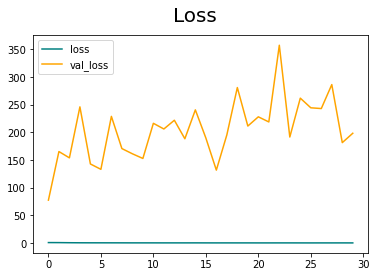

In [68]:
fig = plt.figure()
plt.plot(hist_AD.history['loss'], color='teal', label='loss')
plt.plot(hist_AD.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

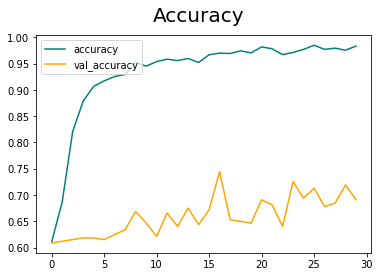

In [69]:
fig = plt.figure()
plt.plot(hist_AD.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist_AD.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

Podemos observar que el performance es peor utilizando aumento de datos. Tengo mis teorías a continuación...
1. Los problemas que me encontré están causando que el modelo no pueda aprender
2. Se necesita un mejor modelo, con más capas o más neuronas con distintos hiperparámetros.
3. Es probable que con otra implementación totalmente diferente del modelo, por ejemplo con VG16, funcione usando aumento de datos.   

De todas formas me siento bien de lo que he logrado y el esfuerzo que tomé por intentar arreglar las cosas. 😀

In [70]:
# Probamos los datos
test_loss, test_acc = model_AD.evaluate(test_new, steps = 10)

10/10 [==============================] - 1s 92ms/step - loss: 350.5991 - accuracy: 0.5625


In [71]:
print("Comparación de resultados entre normal y AD:\n")
print("Resultados antes de Data Augmentation:")
print("Accuracy:", pre.result().numpy())
print("Resultados después de Data Augmentation:")
print("Accuracy:", test_acc)

Comparación de resultados entre normal y AD:

Resultados antes de Data Augmentation:
Accuracy: 0.97354496
Resultados después de Data Augmentation:
Accuracy: 0.5625


### Probando con imagenes de fuera
Ahora probaremos este nuevo modelo usando data augmentation para ver qué nos predice...

In [85]:
img = load_img('j4.jpg',  target_size=(256,256))
img_tensor = img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis = 0)
img_tensor /= 255.

In [73]:
model = models.load_model("tom_and_jerry_AD.h5")

1/1 [==============================] - 0s 22ms/step
[[5.0112176e-05]]
class  0 confindence
JERRY


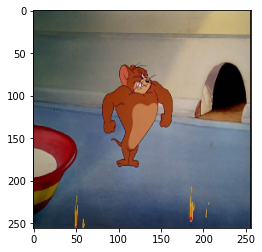

In [86]:
#model response
confidence = model.predict(img_tensor)
predict_class = (confidence > 0.5).astype("int32")
print (confidence)
print ("class ", predict_class[0][0], "confindence", )

if predict_class[0][0] == 0:
  print("JERRY")
else:
  print("TOM")

plt.imshow(img_tensor[0])
plt.show()